Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0521 - val_loss: 0.0382
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0376 - val_loss: 0.0366
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0372 - val_loss: 0.0365
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0369 - val_loss: 0.0360
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0365 - val_loss: 0.0357
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0361 - val_loss: 0.0353
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0357 - val_loss: 0.0353
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0357 - val_loss: 0.0348
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0351 - val_loss: 0.0348
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0353 - val_loss: 0.0347
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 295s 936ms/step


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x70d2e85d7060>
Traceback (most recent call last):
  File "/mnt/A04C91DC4C91AE12/Israil/venv/lib/python3.12/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/mnt/A04C91DC4C91AE12/Israil/venv/lib/python3.12/site-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/mnt/A04C91DC4C91AE12/Israil/venv/lib/python3.12/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() 

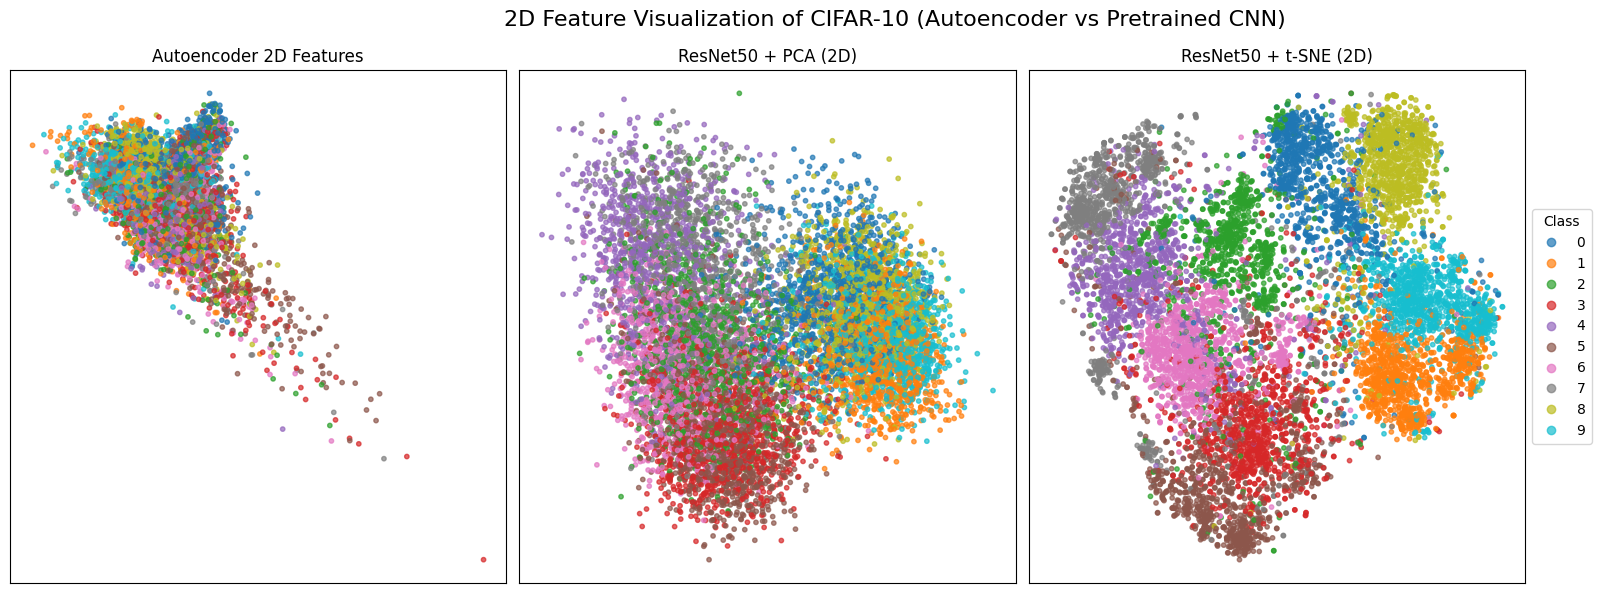

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()


# Autoencoder with 2D Latent Space
input_dim = 32 * 32 * 3
x_train_flat = x_train.reshape((-1, input_dim))
x_test_flat = x_test.reshape((-1, input_dim))

input_img = layers.Input(shape=(input_dim,))
x = layers.Dense(512, activation='relu')(input_img)
x = layers.Dense(128, activation='relu')(x)
encoded = layers.Dense(2, name="latent_features")(x)  # 2D bottleneck
x = layers.Dense(128, activation='relu')(encoded)
x = layers.Dense(512, activation='relu')(x)
decoded = layers.Dense(input_dim, activation='sigmoid')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train_flat, x_train_flat, epochs=10, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

# Encoder model to extract 2D features
encoder = models.Model(input_img, encoded)
autoencoder_features = encoder.predict(x_test_flat)

# ResNet50 features
resized = tf.image.resize(x_test, (224, 224))
resnet_input = preprocess_input(resized * 255.0)
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Fine-tune last few layers
for layer in resnet.layers[:-10]:
    layer.trainable = False
for layer in resnet.layers[-10:]:
    layer.trainable = True

resnet_features = resnet.predict(resnet_input, verbose=1)

# PCA and t-SNE
pca = PCA(n_components=2)
resnet_pca = pca.fit_transform(resnet_features)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
resnet_tsne = tsne.fit_transform(resnet_features)

# Visualization
def plot_features(ax, features, labels, title, cmap='tab10'):
    scatter = ax.scatter(features[:, 0], features[:, 1], c=labels, cmap=cmap, s=10, alpha=0.7)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return scatter

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
scatter1 = plot_features(axes[0], autoencoder_features, y_test, "Autoencoder 2D Features")
scatter2 = plot_features(axes[1], resnet_pca, y_test, "ResNet50 + PCA (2D)")
scatter3 = plot_features(axes[2], resnet_tsne, y_test, "ResNet50 + t-SNE (2D)")

# Add legend only once
legend = axes[2].legend(*scatter3.legend_elements(), title="Class", loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle("2D Feature Visualization of CIFAR-10 (Autoencoder vs Pretrained CNN)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88, right=0.85)
plt.show()
